*RNN_Human_Detection.ipynb* <p style='text-align: right;'> <b> September 20th 2020 </b> </p>
<p style='text-align: right;'> <b> David Diston </b> </p>

# Build an LSTM RNN to Classify between Human and Computer Performances

***Substantial trial-and-error tuning was performed when developing this model. The final model iteration is shown here***

I have chosed to work with LSTM RNN architecture because of its success when dealing with sequential data. Since each row of data in my arrays has 88 observations (one variable/column per piano note), I initially started with a model containing 88 input nodes in an LSTM layer. After trial and error with different input nodes, I found 88 input nodes was the most optimal structure. For other models created in this project, I will show later that the optimal number of input nodes varries. Similar to tuning the number of input nodes, the number of hidden layers, and nodes within those layers were adjusted and tested to find the best model architecture for this problem. 

Based on this tuning, the most optimal model for this project was deterined to be 88 LSTM input nodes, followed by one hidden LSTM layer also with 88 nodes, a hidden dense layer with 1408 nodes, and the final output layer with 2 nodes and softmax activation. I have also included dropout to try and mitigate overfitting.

In [1]:
# Import all libraries for modeling
import numpy as np
import os
import tensorflow
import random

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# I have created a function to load my data that can be called for the training, validation, and test sets
# This function will take in the list of classes, and the directory where to find the data
def training_set(cat, datdir):
    # Using the category labels, I can iterate through each folder
    for category in cat:
        path = os.path.join(datdir, category)
        class_num = categories.index(category)
        # Using the path, and index of the category, I can append both together in a training_data list
        for array in os.listdir(path):
            # Here I am going to use try, to avoid breaking the loop if it comes accross an issue loading a particular array
            try:
                midi_array = np.load(os.path.join(path, array))
                training_data.append([midi_array, class_num])
            except Exception as e:
                pass

In [3]:
# Load Training Data
datadirectory = 'C:/Users/David Diston/Documents/CapstonePythonScripts/HumComp/HumComp_Data'
categories = ['Computer', 'Human']

# I'll instantiate my training_data list
training_data = []

# I will pass the path and categories into my data import function
training_set(categories, datadirectory)

# I am going to shuffle the data for more accurate training
random.shuffle(training_data)

X = []
y = []

# For every array/class pair in the data list, I will append the array and class to the X and y variable respectively
for features, label in training_data:
    X.append(features)
    y.append(label)

In [4]:
# Load Validation Data
datadirectory = 'C:/Users/David Diston/Documents/CapstonePythonScripts/HumComp/HumComp_Validation_Set_Data'
categories = ['Computer', 'Human']

# I am going to use the same data import function I created, so I will reinstantiate the list
training_data = []

# Again I will pass in the categories/class labels and data path for teh validation data
training_set(categories, datadirectory)

# I will shuffle the validation data
random.shuffle(training_data)

X_val = []
y_val = []

# Once again I will break apart the array/class pairs and attach them to the validation variables
for features, label in training_data:
    X_val.append(features)
    y_val.append(label)

In [5]:
# I will convert all data lists to arrays, and reshape to the correct shape for network input
X_train = np.array(X).reshape(-1, 100, 88)
y_train = np.array(y)
X_val = np.array(X_val).reshape(-1, 100, 88)
y_val = np.array(y_val)

# Here I will normalize all the data to improve training
# Since all note velocities are between 0-127, I can divide by 127 to convert all velocities to between 0 and 1
X_train = X_train / 127
X_val = X_val / 127

In [6]:
# I will instantiate my model
HumCom_model = Sequential()

# Through trial and error I have found 88 input nodes to be optimal
# I am also returning a sequence to be passed to my next hidden LSTM layer
# Dropout is used after each layer to prevent overfitting
HumCom_model.add(LSTM(88, input_shape = (X_train.shape[1:]), activation = 'relu', return_sequences = True))
HumCom_model.add(Dropout(0.1))

# My first hidden layer also with relu activation
# A sequence output is not required here since the next layer is dense
HumCom_model.add(LSTM(88, activation='relu'))
HumCom_model.add(Dropout(0.1))

# Trial and error by factors of 44 nodes found that 1408 nodes in the hidden dense layer was optimal
# I experimented with more and less hidden layers and found this arrangement to be optimal
HumCom_model.add(Dense(1408, activation='relu'))
HumCom_model.add(Dropout(0.1))

# The final output of the model will predict between the two classes
HumCom_model.add(Dense(2, activation='softmax'))

In [7]:
# I am going to use the adam optimizer with an average learning rate and decay
# I also had issues with gradient explosion, so I introduce value clipping of 0.5
opt = Adam(lr = 0.001, decay = 0.00001, clipvalue=0.5)

# Here I compile my model with the loss function, the optimizer, an accuracy metric
HumCom_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = opt,
    metrics=['accuracy'])

# Prior to training I print out a summary of the model I have created
HumCom_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 88)           62304     
_________________________________________________________________
dropout (Dropout)            (None, 100, 88)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 88)                62304     
_________________________________________________________________
dropout_1 (Dropout)          (None, 88)                0         
_________________________________________________________________
dense (Dense)                (None, 1408)              125312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [8]:
# By including this checkpoint I can save a copy of the weights from the best performing epoch
# I will identify the best performing epoch by monitoring the validation accuracy
checkpoint = ModelCheckpoint('Models/HumCom_Model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Now time to fit the model
# I set epochs to 20 since I found that after 20 epochs the model tends to start overfitting and there is no further loss reduction
HumCom_model.fit(X_train, y_train,
               batch_size = 50,
               epochs = 20,
               validation_data=(X_val, y_val),
               callbacks=callbacks_list)

Epoch 1/20
320/320 [==============================] - ETA: 0s - loss: 30520976.0000 - accuracy: 0.5824
Epoch 00001: val_accuracy improved from -inf to 0.64650, saving model to Models/HumCom_Model.hdf5
320/320 [==============================] - 21s 66ms/step - loss: 30520976.0000 - accuracy: 0.5824 - val_loss: 0.6415 - val_accuracy: 0.6465
Epoch 2/20
320/320 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.7099
Epoch 00002: val_accuracy improved from 0.64650 to 0.73900, saving model to Models/HumCom_Model.hdf5
320/320 [==============================] - 21s 65ms/step - loss: 0.5623 - accuracy: 0.7099 - val_loss: 3730435.2500 - val_accuracy: 0.7390
Epoch 3/20
320/320 [==============================] - ETA: 0s - loss: 6683548.0000 - accuracy: 0.7229
Epoch 00003: val_accuracy did not improve from 0.73900
320/320 [==============================] - 21s 66ms/step - loss: 6683548.0000 - accuracy: 0.7229 - val_loss: 0.7006 - val_accuracy: 0.5000
Epoch 4/20
320/320 [=======

In [9]:
# In addition to saving the best weights with callback, I will also save a copy of the full model I created
HumCom_model.save('Models/HumCom_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Models/HumCom_model\assets


In [10]:
# Here I import the libraries and metrics for evaluating the success of my model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [11]:
# The standard confusion matrix looks terrible and is difficult to read
# The below function will help visually display the confusion matrix results
# I got the idea for this function from a previous LSTM study, and have adapted it to my purposes below
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):

    # Here I am calling the plot of the confusion matrix with the Blue cmap as standard
    # I found that the 'nearest' interpolation produced the clearest results
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # I will also include the colour bar for reference
    plt.colorbar()
    # I set the numer of ticks on the x and y axis to the number of classes which will be useful for multiclass models
    tick_marks = np.arange(len(classes))
    # Here I am going to rotate the x-axis ticks 45 degrees to avoid crouding with the x-axis label
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # The threshold is half of the maximum value present in the confusion matrix
    thresh = cm.max() / 2
    # This for loop places the correct numerical text in the correct box, and was borrowed from a previous project
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Finally I will include axis labels for clarity
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

The above code was inspired by [this project.](https://colab.research.google.com/drive/1ISfhxFDntfOos7cOeT7swduSqzLEqyFn)

Only after building this code did I realize that `sklearn.metrics` has a `plot_confusion_matrix` function that works in a very similar way. However to accurately show my process I have included my own function as I originally created it (with inspiration as referenced).

Now I can load the test data in the same way I loaded the training and validation data above.

In [12]:
# Load Test Data
datadirectory = 'C:/Users/David Diston/Documents/CapstonePythonScripts/HumComp/HumComp_Test_Set_Data'
categories = ['Computer', 'Human']

# Similar to above I will instantiate the data list and use the data loading function I created
training_data = []
    
training_set(categories, datadirectory)

# I will again shuffle the data, though this process is  not required for the testing data
random.shuffle(training_data)

X_test = []
y_test = []

# Once again I will split the arrays and their class labels into their respective variables
for features, label in training_data:
    X_test.append(features)
    y_test.append(label)

# I will convert to array and reshape the data
X_test = np.array(X_test).reshape(-1, 100, 88)
y_test = np.array(y_test)

# I will also normalize the test data to values between 0 and 1
X_test = X_test / 127

Finally, I can use the test data to make predictions using the model built above, and plot the confusion matrix for a visual representation of the classification success of the model.

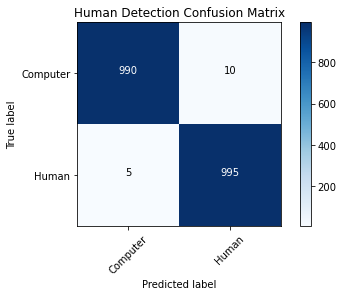

In [15]:
# I will use the predict function to get predictions based on the test set arrays
results = HumCom_model.predict(X_test, batch_size = 10)

# I will convert the class probabilities into actual class predictions
predicted_classes = np.argmax(results, axis=1)

# Names of predicted classes
class_names = ['Computer', 'Human']

# Using sklearn and the true and predicted class labels I will create a confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted_classes)

# Finally I will plot the confusion matrix using the above function
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)
plt.title('Human Detection Confusion Matrix')
plt.show()

In [14]:
# I will also print a classification report of the class predictions to better understand the errors
CR = classification_report(y_test, predicted_classes)
print(CR)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



Overall I am very happy with the high validation and test accuracy I was able to achieve with my model. These results were not entirely unexpected. Even though it is often difficult for the human ear to differentiate bewteen human-performed and computer-performed midi files, as has been discussed so far these types of files are quite different at the data level. 

Now that I have established that computer and human performed midi files can be identified, I will build a model that attempts to classify the composer of a piece of music.

<p style='text-align: right;'> <b> Next Step: </b> Preprocess data required to build a Composer classification model - <em> Composer_Model_Data_Preparation.ipynb </em> </p>